# Single character recognition model
- Our goal with this model is to use convolutional neural networks to recognize a single character on an image, similarly to what is done with the famous MNIST handwritten-digit dataset. 
- In fact, we will use a very similar dataset called EMNIST, and more specifically the "by-class EMNIST" which contains a total of 894,253 images. This version is unbalanced, so characters appear with different frequencies. However, the frequencies match the appearance frequencies of characters in the English language (stated on the dataset website, but we will check this). 
- We previously tried using the smaller, balanced datasets, but it seemed like it was more important to have as much training data as possible to have a robust model, since this one will be used on the segmentation algorithm. 

In [13]:
### LOAD PACKAGES ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

import random
from sklearn.utils import shuffle

In [14]:
### LOAD DATASET ### (already split in train/test sets)

train_file = pd.read_csv('HWT_project/data_2/emnist-byclass-train.csv')
train_file = np.array(train_file)
X_train = train_file[:,1:]
X_train = X_train.reshape((X_train.shape[0],28,28))
y_train = train_file[:,0]
y_train = y_train.reshape((y_train.shape[0],1))

test_file = pd.read_csv('HWT_project/data_2/emnist-byclass-test.csv')
test_file = np.array(test_file)
X_test = test_file[:,1:]
X_test = X_test.reshape((X_test.shape[0],28,28))
y_test = test_file[:,0]
y_test = y_test.reshape((y_test.shape[0],1))

digits = False    # If you want digits in the dataset (specify proportion below)
nodigits = True   # No digits at all
#nocaps = True     # If you want no caps at all

if not digits:
    all_digits = [i for i in range(10)]
    digit_indices = []
    for i in range(len(X_train)):
        if y_train[i][0] in all_digits:
            if random.random() > 0.0:     # specify proportion
                digit_indices.append(i)
    X_train = np.delete(X_train,digit_indices,axis=0)
    y_train = np.delete(y_train,digit_indices,axis=0)
    
    digit_indices = []
    for i in range(len(X_test)):
        if y_test[i][0] in all_digits:
            if random.random() > 0.0:
                digit_indices.append(i)
    X_test = np.delete(X_test,digit_indices,axis=0)
    y_test = np.delete(y_test,digit_indices,axis=0)
    
    if nodigits:
        y_train -= 10
        y_test -= 10

"""
if nocaps:
    caps = [i for i in range(10,36)]
    
    caps_indices = []
    for i in range(len(X_train)):
        if y_train[i][0] in caps:
            caps_indices.append(i)
    X_train = np.delete(X_train,caps_indices,axis=0)
    y_train = np.delete(y_train,caps_indices,axis=0)
    
    caps_indices = []
    for i in range(len(X_test)):
        if y_test[i][0] in caps:
            caps_indices.append(i)
    X_test = np.delete(X_test,caps_indices,axis=0)
    y_test = np.delete(y_test,caps_indices,axis=0)
    
    y_train -= 26
    y_test -= 26
"""
    
for i in range(X_train.shape[0]):
    X_train[i] = X_train[i].T
for i in range(X_test.shape[0]):
    X_test[i] = X_test[i].T
    
X_train = X_train.reshape((X_train.shape[0],28,28,1))
X_test = X_test.reshape((X_test.shape[0],28,28,1))

print("Quick check on the shapes: ", X_train.shape, y_train.shape,X_test.shape,y_test.shape)

Quick check on the shapes:  (352896, 28, 28, 1) (352896, 1) (58404, 28, 28, 1) (58404, 1)


[13]
N


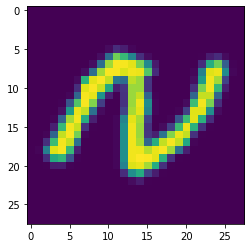

In [15]:
## Check alignment

plt.imshow(X_train[150000])
print(y_train[150000])
print(chr(78))

### Parsing the data
The dataset includes a mapping textfile which is used to map a character to its class label. Each class label (integers from 0 to n) is mapped to the ASCII representation of the character. 

In [16]:
with open('HWT_project/data_2/emnist-balanced-mapping.txt','r') as mapp:
    d = dict()
    if nodigits:
        for l in mapp.readlines():
            if int(l.split()[0]) > 9:
                d[int(l.split()[0])-10] = int(l.split()[1])
    else:
        for l in mapp.readlines():
            d[int(l.split()[0])] = int(l.split()[1])

d_disp = {k:chr(d[k]) for k in d.keys()}
print(d)
print("Map: ", d_disp)

{0: 65, 1: 66, 2: 67, 3: 68, 4: 69, 5: 70, 6: 71, 7: 72, 8: 73, 9: 74, 10: 75, 11: 76, 12: 77, 13: 78, 14: 79, 15: 80, 16: 81, 17: 82, 18: 83, 19: 84, 20: 85, 21: 86, 22: 87, 23: 88, 24: 89, 25: 90, 26: 97, 27: 98, 28: 99, 29: 100, 30: 101, 31: 102, 32: 103, 33: 104, 34: 105, 35: 106, 36: 107, 37: 108, 38: 109, 39: 110, 40: 111, 41: 112, 42: 113, 43: 114, 44: 115, 45: 116, 46: 117, 47: 118, 48: 119, 49: 120, 50: 121, 51: 122}
Map:  {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'a', 27: 'b', 28: 'c', 29: 'd', 30: 'e', 31: 'f', 32: 'g', 33: 'h', 34: 'i', 35: 'j', 36: 'k', 37: 'l', 38: 'm', 39: 'n', 40: 'o', 41: 'p', 42: 'q', 43: 'r', 44: 's', 45: 't', 46: 'u', 47: 'v', 48: 'w', 49: 'x', 50: 'y', 51: 'z'}


The frequencies shown below prove that the character frequencies are close to the appearance frequencies in the English language. This is true for small caps, as well as caps. However, this might be a problem: because the frequency of caps with respect to small caps is much smaller in reality. The same goes for digits, which are dominant in the dataset. If this appears to be a problem later, we could seek to personalize our dataset or look at other methods later.

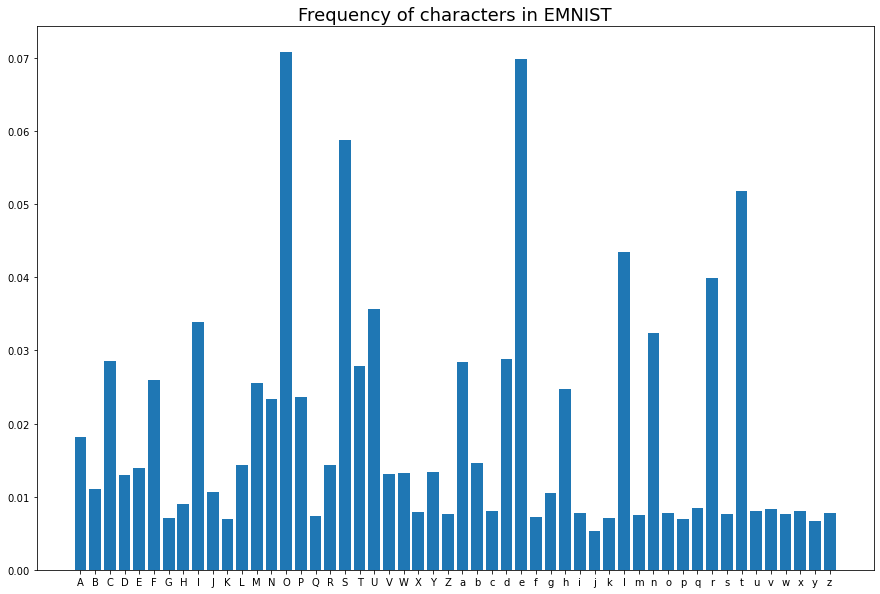

In [17]:
unique, counts = np.unique(y_train, return_counts=True)
counts = counts/np.sum(counts)
plt.figure(figsize=(15,10))
plt.bar(unique,counts)
plt.xticks(unique,d_disp.values())
plt.title('Frequency of characters in EMNIST', fontsize=18)
plt.show()

We parse the data by standardizing the image matrices to avoid gradient explosion. We also use one-hot encoding of the labels to be able to use the categorical cross-entropy loss later.

In [18]:
### PARSE DATA ###

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
y_train = to_categorical(y_train.astype('uint8'))
y_test = to_categorical(y_test.astype('uint8'))
X_train, y_train = shuffle(X_train, y_train)

## ADD NOISE
for i in range(len(X_train)):
    X_train[i] += np.abs(np.random.normal(0,0.8,(28,28)).reshape(28,28,1))

print(y_train.shape)

(352896, 52)


Let's display a few images to make sure the shuffling did not alter the labelling.

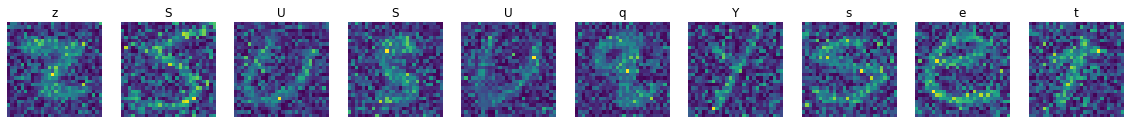

In [19]:
### DISPLAY n IMAGES ###
n = 10

f,ax = plt.subplots(1,n,figsize=(2*n,2*n))
for i in range(n):
    t = random.randint(0,X_train.shape[0])
    ax[i].imshow(X_train[t,:,:,0])
    ax[i].set_title(chr(d[np.argmax(y_train[t])]))
    ax[i].axis('off')
plt.show()

The model we define is a convolutional neural network with 3 filter layers. This model is similar to what one would use for the MNIST dataset. Since there are a bit more classes than the latter, we though that the model would work well if we added some complexity by adding filters throughout the layers. The rest is similar to what we implemented in TD.

In [8]:
def Model(input_shape, num_classes):
    
    model = keras.models.Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(128,activation ="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(64,activation ="relu"))
    model.add(Dense(num_classes,activation ="softmax"))
    
    model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [9]:
model = Model(X_train.shape[1:], y_train.shape[1])

In [10]:
def train(model, x: np.array, y: np.array,
                x_target: np.array, y_target: np.array,
                batch_size: int = 32, epochs: int = 10):
    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
    model.fit(x, y, batch_size=batch_size, epochs=epochs, callbacks=[e_stop], validation_data=(x_target, y_target))

In [11]:
train(model,X_train,y_train,X_test,y_test,128,20)

Epoch 1/20
2757/2757 [==============================] - 79s 29ms/step - loss: 0.7003 - accuracy: 0.7790 - val_loss: 0.4405 - val_accuracy: 0.8397
Epoch 2/20
2757/2757 [==============================] - 80s 29ms/step - loss: 0.4699 - accuracy: 0.8332 - val_loss: 0.4368 - val_accuracy: 0.8411
Epoch 3/20
2757/2757 [==============================] - 79s 29ms/step - loss: 0.4394 - accuracy: 0.8417 - val_loss: 0.4272 - val_accuracy: 0.8426
Epoch 4/20
2757/2757 [==============================] - 76s 28ms/step - loss: 0.4251 - accuracy: 0.8455 - val_loss: 0.3952 - val_accuracy: 0.8533
Epoch 5/20
2757/2757 [==============================] - 76s 28ms/step - loss: 0.4141 - accuracy: 0.8483 - val_loss: 0.3813 - val_accuracy: 0.8572
Epoch 6/20
2757/2757 [==============================] - 76s 28ms/step - loss: 0.4054 - accuracy: 0.8503 - val_loss: 0.3867 - val_accuracy: 0.8552
Epoch 7/20
2757/2757 [==============================] - 76s 28ms/step - loss: 0.4007 - accuracy: 0.8518 - val_loss: 0.3899 -

In [12]:
model.save('model_char_noised02')

INFO:tensorflow:Assets written to: model_char_noised02/assets


In [ ]:
# model_char_v1 :
# best acc: 0.8639
# best val_acc: 0.8679

# model_char_v2 :
# best acc: 0.8704
# best val_acc: 0.8748

# model_char_digitprob02
# best acc: 0.8290
# best val_acc: 0.8365

# model_char_nodigit
# best acc: 0.8625
# best val_acc: 0.8622 